In [1]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from scipy.signal import argrelextrema

In [2]:
def V(phi):
    """
    Function defining the potential, V(phi) = a*phi^2 -b*phi^3 + c*phi^4 
    The parameters a, b, c should be definied s.t we get a 1st order PT, i.e a bump
    Important to only have one bump, and hence only 2 minimas.

    @param phi: our scalar field, should be array
    @return pot: The effective potential
            phiTrueVacuum: The value of phi at the true vacuum
            phiFalseVacuum: The value of phi at the false vacuum
    """
    # The potential
    pot = +a*phi**2 -b*phi**3 + c*phi**4

    # Find the global and local minimas, i.e the true and false vacua
    # argrelextrema returns the indices of the minimas
    indexMinimas = argrelextrema(pot, np.less)

    # Find the value of the potential at the minimas
    potMinima = pot[indexMinimas[0]]

    # The true vacuum is the global minima, i.e the min value of the values
    # of the potential at the different minimas. Get the index.
    indexPhiTrue =  np.argwhere(potMinima == potMinima.min())[0]

    # From the index we find the value of phi at the true vacuum
    phiTrueVacuum = phi[indexMinimas[0]][indexPhiTrue[0]]

    # The index of the false vacuum is simply the other one and we get phi 
    # at the false vacuum
    phiFalseVacuum = phi[indexMinimas[0]][~indexPhiTrue[0]]

    return pot, phiTrueVacuum, phiFalseVacuum

In [3]:
def makePlotsPotential(phi_span, potential):
    """
    Function to make plots for the potential. One of the potential and one of 
    the inverted potential to visualize the potential for the point particle 
    that we use later on when calculating the bounce. 
     

    @param phi_span: The span of phi, i.e x-axis
           potential: The potential V(phi), i.e y-axis, for every point of phi_span
    @return Two plots in one figure, one of V(phi) and the other -V(phi)
    """

    # ADD POINT OF PHI_F AND PHI_T
    plt.figure()
    ax = plt.subplot(121)
    ax.plot(phi_span, potential)
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$V(\phi)$')             

    ax = plt.subplot(122)
    ax.plot(phi_span, -potential)
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$- V(\phi)$')
    #plt.show()

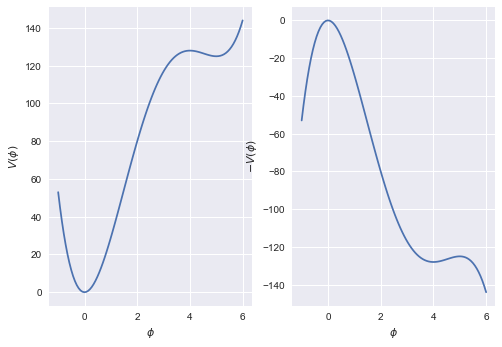

In [4]:
# Set parameters for the potential, V(phi) = a*phi^2 -b*phi^3 + c*phi^4
# Values from AnyBubble article
a = 40
b = 12
c = 1

# Span of phi also from AnyBubble article
phi_span = np.linspace(-1, 6, 100)
potential, phiTrueVacuumAB, phiFalseVacuumAB = V(phi_span)
makePlotsPotential(phi_span, potential)

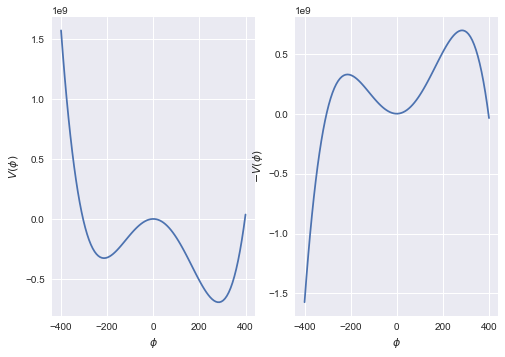

In [5]:
# Set parameters for the potential, V(phi) = a*phi^2 -b*phi^3 + c*phi^4
# Form from Rubakov, values chosen to be SM-like
a = -125**2
b = 12
c = 125**2/(2*246**2)

phi_span = np.linspace(-400, 400, 100)
potential, phiTrueVacuumSM, phiFalseVacuumSM = V(phi_span)
makePlotsPotential(phi_span, potential)

In [6]:
def dVdphi(phi):
    """
    Function defining the derivative of the potential, given it's on the 
    form V(phi) = a*phi^2 -b*phi^3 + c*phi^4

    @param phi: our scalar field
    @return The derivative of the potential
    """
    return 2*a*phi -3*b*phi**2 + 4*c*phi**3

In [44]:
def equations(r, y):
    """
    Function setting our equation system from the EOM of the bounce. 
    Turning equation of 2nd order ODE, to system of two 1st order ODEs.

        From: dphi^2/dr^2 + (alpha/r)*dphi/dr = dV/dphi

            introduce v = dphi/dr, s.t dv/dr = dphi^2/dr^2
            and then y = [phi, v], dy/dr = [dphi/dr, dv/dr]

        To: dy/dr = [dphi/dr, dv/dr] = [v, -(alpha/r)*dphi/dr + dV/dphi]                                              

    @param r: For T=0, r = sqrt(t^2 + x^2), for finite T r = r
           y: Array of phi and dphi/dr
           alpha: D-1 term, equals either 3 in 4D or 2 in 3D
    @return dydr: Array of dphi/dr and dphi^2/dr^2
    """
    # Pick out the values from y = [phi, v]
    phi = y[0]
    v = y[1]        # v = dphi/dr

    # When dimension = 4
    alpha = 3

    # Define the derivatives
    dphidr = v
    dvdr = - (alpha/r)*v + dVdphi(phi)      # - (alpha/r)*v is the friction term, dVdphi(phi) the derivative of the potential (-)V(phi)
    
    # Set dy/dr = [dphi/dr, dv/dr]
    dydr = np.array([dphidr, dvdr])
    
    return dydr


In [52]:
def shooting(r, phiTrueVacuum, phiFalseVacuum, undershoot):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    tol = 1e-3
    max_iters = 30

    # If the inparameter 'undershoot' is None we estimate the parameter
    # Does not work atm. 
    # if undershoot is None:
    #     undershoot = (phiFalseVacuum - phiTrueVacuum)/4

    # When phi_T is placed to the right of phi_F
    if phiTrueVacuum > phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an overshoot and low an undershoot.
        high = phiTrueVacuum
        low = phiTrueVacuum + undershoot

    # When phi_T is placed to the left of phi_F
    elif phiTrueVacuum < phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an undershoot and low an overrshoot.
        high = phiTrueVacuum + undershoot
        low = phiTrueVacuum

    print('phi_T = ', phiTrueVacuum, 'phi_F = ', phiFalseVacuum)
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])

    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equations, xspan, f0, t_eval = r)      

        # The numerical solution from the solver
        y_num = sol.y[0, :]

        # Felsök
        print('low =', low, 'high = ', high)
        print('count: ', count, 'Value of last point in numerical: ', y_num[-1], 'Initial guess: ', phi0)

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:        
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # the particle rolls to the wrong direction, i.e y_num is bigger than phi_T
            if y_num[-1] < (phiFalseVacuum + tol) or y_num[-1] > phiTrueVacuum:                                      
                high = phi0

            # In all the other cases we have an undershoot                  
            else:                           
                low = phi0  

        # When phi_T is placed to the left of phi_F
        elif phiTrueVacuum < phiFalseVacuum:
            # We get an overshoot if the last point of y_num is bigger than phi_F or if
            # the particle rolls to the wrong direction, i.e y_num is less than phi_T
            if y_num[-1] < phiTrueVacuum or y_num[-1] > (phiFalseVacuum + tol):                                      
                low = phi0

            # In all the other cases we have an undershoot
            # Fix condition                  
            else:                           
                high = phi0

    return y_num

phi_T =  -0.010101010101010166 phi_F =  5.0101010101010095
low = -0.010101010101010166 high =  1.9898989898989898
count:  1 Value of last point in numerical:  1.8253152286105475e-05 Initial guess:  0.9898989898989898
low = -0.010101010101010166 high =  0.9898989898989898
count:  2 Value of last point in numerical:  8.923254708915688e-06 Initial guess:  0.48989898989898983
low = -0.010101010101010166 high =  0.48989898989898983
count:  3 Value of last point in numerical:  4.117272107666736e-06 Initial guess:  0.23989898989898983
low = -0.010101010101010166 high =  0.23989898989898983
count:  4 Value of last point in numerical:  1.5614368901169305e-06 Initial guess:  0.11489898989898983
low = -0.010101010101010166 high =  0.11489898989898983
count:  5 Value of last point in numerical:  3.0865595679635667e-07 Initial guess:  0.052398989898989834
low = -0.010101010101010166 high =  0.052398989898989834
count:  6 Value of last point in numerical:  -3.0608234783004564e-07 Initial guess:  0.0

Text(0, 0.5, '$\\phi_B$(r)')

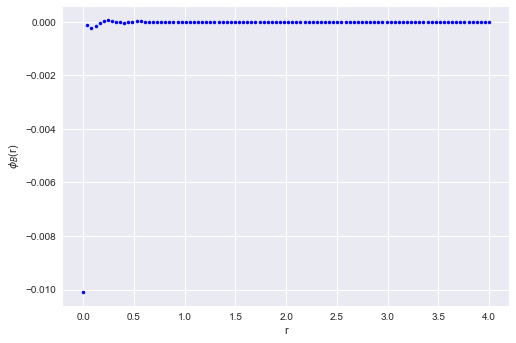

In [53]:
r = np.linspace(0.00001, 4, 100)
y_num = shooting(r, phiTrueVacuumAB, phiFalseVacuumAB, undershoot = 2)
plt.plot(r, y_num, 'b.')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')            

-125.25252525252526 161.6161616161617


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

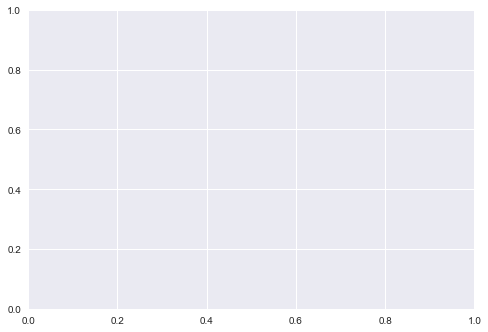

In [13]:
r = np.linspace(0.00001, 4, 100)
y_num = shooting(r, phiTrueVacuumSM, phiFalseVacuumSM)
plt.plot(r, y_num, 'b.') 